In [1]:
import numpy as np 
import _pickle as cPickle
import gzip
import os
from sklearn.utils import shuffle
from tqdm import tqdm

In [2]:
# utility functions

def one_hot_encoded(y, num_class):
    n = y.shape[0]
    onehot = np.zeros((n, num_class), dtype="int32")
    for i in range(n):
        idx = y[i]
        onehot[i][idx] = 1
    return onehot


def check_accuracy(y_true, y_pred):
    return np.mean(y_pred == y_true)  # both are not one hot encoded


def softmax(x):
    # софтмакс сделан более устойчивым с помощью вычитания np.max
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)


# l2 regularization
def l2_reg(layers, lam=0.001):
    reg_loss = 0.0
    for layer in layers:
        if hasattr(layer, 'W'):
            reg_loss += 0.5 * lam * np.sum(layer.W * layer.W)
    return reg_loss


# l2 regularization grad
def delta_l2_reg(layers, grads, lam=0.001):
    for layer, grad in zip(layers, reversed(grads)):
        if hasattr(layer, 'W'):
            grad[0] += lam * layer.W
    return grads

In [3]:
# функция для проверки грандиентов
def eval_numerical_gradient(f, x, verbose=False, h=0.00001):
    """Evaluates gradient df/dx via finite differences:
    df/dx ~ (f(x+h) - f(x-h)) / 2h
    Adopted from https://github.com/ddtm/dl-course/
    """
    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print (ix, grad[ix])
        it.iternext() # step to next dimension

    return grad

In [4]:
# dout - upstream gradient
# gradInput - upstream_gradient*local_gradient
# forward = ReLU(X)
class ReLU():
    def __init__(self):
        self.params = []
        self.gradInput = None

    def forward(self, X, mode):
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dout, mode):
        self.gradInput = dout.copy()
        self.gradInput[self.X <= 0] = 0
        return self.gradInput, []

In [5]:
points = np.linspace(-1, 1, 10*12).reshape([10, 12])
relu = ReLU()
f = lambda x: relu.forward(x, mode='train').sum(axis=1).sum()
res = f(points)
numeric_grads = eval_numerical_gradient(f, points)
print(numeric_grads)
inp_grad = np.ones(shape=(10, 12))
grads = relu.backward(inp_grad, mode='train')[0]
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [7]:
# Xavier init - input dispersion is similar to output dispersion
# for convergence
# 
class Linear():
    def __init__(self, in_size, out_size):
        # Xavier init
        self.W = np.random.randn(in_size, out_size) / np.sqrt(in_size + out_size/ 2.)
        self.b = np.zeros((1, out_size))
        self.params = [self.W, self.b]
        self.gradW = None
        self.gradB = None
        self.gradInput = None

    def forward(self, X, mode):
        self.X = X
        out = self.X.dot(self.W) + self.b
        return out

    def backward(self, dout, mode):
        self.gradW = self.X.T.dot(dout)
        self.gradB = np.mean(dout, axis=0)
        self.gradInput = dout.dot(self.W.T)
        return self.gradInput, [self.gradW, self.gradB]

In [8]:
points = np.linspace(-1, 1, 10*12).reshape([10, 12])
linear = Linear(12, 5)
f = lambda x: linear.forward(x, mode='train').sum(axis=1).sum()
res = f(points)
numeric_grads = eval_numerical_gradient(f, points)
print(numeric_grads)
inp_grad = np.ones(shape=(10, 5))
grads = linear.backward(inp_grad, mode='train')[0]
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

[[-7.51130580e-04  6.14180038e-01  2.11436234e-01  2.22470347e-01
  -1.84192922e-01  7.54657708e-01  8.95621202e-02  1.29161640e-01
   6.29682943e-01 -2.48729555e-01 -2.31738277e-01 -1.00379699e+00]
 [-7.51130580e-04  6.14180038e-01  2.11436234e-01  2.22470347e-01
  -1.84192922e-01  7.54657708e-01  8.95621202e-02  1.29161640e-01
   6.29682943e-01 -2.48729555e-01 -2.31738277e-01 -1.00379699e+00]
 [-7.51130580e-04  6.14180038e-01  2.11436234e-01  2.22470347e-01
  -1.84192922e-01  7.54657708e-01  8.95621202e-02  1.29161640e-01
   6.29682943e-01 -2.48729555e-01 -2.31738277e-01 -1.00379699e+00]
 [-7.51130580e-04  6.14180038e-01  2.11436234e-01  2.22470347e-01
  -1.84192922e-01  7.54657708e-01  8.95621202e-02  1.29161640e-01
   6.29682943e-01 -2.48729555e-01 -2.31738277e-01 -1.00379699e+00]
 [-7.51130580e-04  6.14180038e-01  2.11436234e-01  2.22470347e-01
  -1.84192922e-01  7.54657708e-01  8.95621202e-02  1.29161640e-01
   6.29682943e-01 -2.48729555e-01 -2.31738277e-01 -1.00379699e+00]
 [-7.

In [9]:
class CrossEntropyLoss(object):
    def forward(self, X, y):
        # y can only be 1 or 0
        self.m = y.shape[0]
        self.p = softmax(X)
        # -log(p_true)
        cross_entropy = -np.log(self.p[range(self.m), y])
        loss = np.sum(cross_entropy) / self.m
        return loss

    def backward(self, X, y):
        dx = self.p.copy()
        dx[range(self.m), y] -= 1
        dx /= self.m
        return dx

## NN implementation

In [10]:
class NN:
    def __init__(self, loss_func=CrossEntropyLoss(), mode = 'train'):
        self.layers = []
        self.params = []
        self.loss_func = loss_func
        self.grads = []
        self.mode = mode

    def add_layer(self, layer):
        self.layers.append(layer)
        self.params.append(layer.params)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X, self.mode)
        return X

    def backward(self, dout):
        self.clear_grad_param()
        for layer in reversed(self.layers):
            dout, grad = layer.backward(dout, self.mode)
            self.grads.append(grad)
        return self.grads

    def train_step(self, X, y):
        out = self.forward(X)
        loss = self.loss_func.forward(out, y)
        dout = self.loss_func.backward(out, y)
        loss += l2_reg(self.layers)
        grads = self.backward(dout)
        grads = delta_l2_reg(self.layers, grads)
        return loss, grads

    def predict(self, X):
        X = self.forward(X)
        return np.argmax(softmax(X), axis=1)

    def dispGradParam():
        print(self.grads)
    
    def clear_grad_param(self):
        self.grads = []

In [11]:
# SGD with momentum
def update(velocity, params, grads, learning_rate=0.001, mu=0.9):
    for v, p, g, in zip(velocity, params, reversed(grads)):
        for i in range(len(g)):
            v[i] = mu * v[i] + learning_rate * g[i]
            p[i] -= v[i]

# get minibatches
def minibatch(X, y, minibatch_size):
    n = X.shape[0]
    minibatches = []
    X, y = shuffle(X, y)

    for i in range(0, n , minibatch_size):
        X_batch = X[i:i + minibatch_size, ...]
        y_batch = y[i:i + minibatch_size, ...]

        minibatches.append((X_batch, y_batch))
    return minibatches

In [12]:
def train(net, X_train, y_train, minibatch_size, epoch, learning_rate, mu=0.9,
          verbose=True, X_val=None, y_val=None, nesterov=True):
    val_loss_epoch = []
    minibatches = minibatch(X_train, y_train, minibatch_size)
    minibatches_val = minibatch(X_val, y_val, minibatch_size)

    c = 0 
    for i in range(epoch):
        loss_batch = []
        val_loss_batch = []
        velocity = []
        for param_layer in net.params:
            p = [np.zeros_like(param) for param in list(param_layer)]
            velocity.append(p)

        if verbose:
            print("Epoch {0}".format(i + 1))

        # iterate over mini batches
        # for X_mini, y_mini in tqdm(minibatches):
        for X_mini, y_mini in minibatches:
            loss, grads = net.train_step(X_mini, y_mini)
            loss_batch.append(loss)
            update(velocity, net.params, grads,
                            learning_rate=learning_rate, mu=mu)

        # for X_mini_val, y_mini_val in tqdm(minibatches_val):
        for X_mini_val, y_mini_val in minibatches_val:
            # валидация, можно сделать просто форвард
            val_loss, _ = net.train_step(X_mini, y_mini)
            val_loss_batch.append(val_loss)

        # accuracy of model at end of epoch after all mini batch updates   
        if verbose:
            m_train = X_train.shape[0]
            m_val = X_val.shape[0]
            y_train_pred = np.array([], dtype="int64")
            y_val_pred = np.array([], dtype="int64")

            for i in range(0, m_train, minibatch_size):
                X_tr = X_train[i:i + minibatch_size, : ]
                y_tr = y_train[i:i + minibatch_size, ]
                y_train_pred = np.append(y_train_pred, net.predict(X_tr))

            for i in range(0, m_val, minibatch_size):
                X_va = X_val[i:i + minibatch_size, : ]
                y_va = y_val[i:i + minibatch_size, ]
                y_val_pred = np.append(y_val_pred, net.predict(X_va))

            train_acc = check_accuracy(y_train, y_train_pred)
            val_acc = check_accuracy(y_val, y_val_pred)

            mean_train_loss = sum(loss_batch) / float(len(loss_batch))
            mean_val_loss = sum(val_loss_batch) / float(len(val_loss_batch))

            # early stopping with patience = 5 on val loss
            if len(val_loss_epoch) == 0:
                val_loss_epoch.append(mean_val_loss)
            else:
                for j in val_loss_epoch[-5:]:
                    if mean_val_loss > j:
                        c += 1
                    else:
                        c = 0
                if c > 5:
                    print('Early stopping')
                    return net
                else:
                    c = 0
                    val_loss_epoch.append(mean_val_loss)    

            print("Loss = {0} | Training Accuracy = {1} | " \
                  "Val Loss = {2} | Val Accuracy = {3}".format(
                mean_train_loss, train_acc, mean_val_loss, val_acc))
    return net

In [13]:
# Get preprocessed training and validation data

X_train = np.array([
    [1, 2, 1, 2],
    [2, 4, 2, 4],
    [2, 1, 2, 1],
    [4, 2, 4, 2],
])

y_train = np.array([0, 1, 0, 1])
X_val = X_train.copy()
y_val = y_train.copy()

print(X_train.shape)
print(X_val.shape)

# define neural net
model = NN()

# add some layers
model.add_layer(Linear(4, 100))
model.add_layer(ReLU())
model.add_layer(Linear(100, 100))
model.add_layer(ReLU())
model.add_layer(Linear(100, 2))

model = train(model, X_train , y_train, minibatch_size=4, epoch=100,
           learning_rate=0.1, X_val=X_val, y_val=y_val)

(4, 4)
(4, 4)
Epoch 1
Loss = 0.7959107968358331 | Training Accuracy = 0.5 | Val Loss = 0.6946165950029364 | Val Accuracy = 0.5
Epoch 2
Loss = 0.6946165950029364 | Training Accuracy = 0.5 | Val Loss = 0.6870352521997738 | Val Accuracy = 0.5
Epoch 3
Loss = 0.6870352521997738 | Training Accuracy = 0.5 | Val Loss = 0.6835600640754544 | Val Accuracy = 0.5
Epoch 4
Loss = 0.6835600640754544 | Training Accuracy = 0.5 | Val Loss = 0.6807154117016951 | Val Accuracy = 0.5
Epoch 5
Loss = 0.6807154117016951 | Training Accuracy = 0.5 | Val Loss = 0.6782148086215168 | Val Accuracy = 0.5
Epoch 6
Loss = 0.6782148086215168 | Training Accuracy = 0.5 | Val Loss = 0.675986346354122 | Val Accuracy = 0.5
Epoch 7
Loss = 0.675986346354122 | Training Accuracy = 0.5 | Val Loss = 0.673924271067078 | Val Accuracy = 0.5
Epoch 8
Loss = 0.673924271067078 | Training Accuracy = 0.5 | Val Loss = 0.671963404668465 | Val Accuracy = 0.5
Epoch 9
Loss = 0.671963404668465 | Training Accuracy = 0.5 | Val Loss = 0.6700804379570

## Mnist training

In [14]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [15]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [16]:
y = y.astype(np.int32)
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.25,
                                                  shuffle=True,
                                                  random_state=0)

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

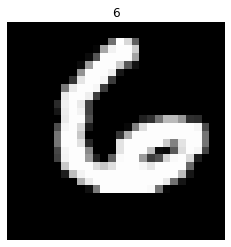

In [19]:
# visualize data
def vis(img, label):
    plt.imshow(img, cmap='gray')
    plt.title(label)
    plt.axis('off')
    plt.show()

vis_idx = 0
vis(X_train[vis_idx].reshape(-1, 28), y_train[vis_idx])

In [20]:
print(X_train.shape)
print(X_val.shape)

# define neural net
model = NN()

# add some layers
model.add_layer(Linear(X_train.shape[1], 100))
model.add_layer(ReLU())
model.add_layer(Linear(100, 100))
model.add_layer(ReLU())
model.add_layer(Linear(100, 10))

model = train(model, X_train , y_train, minibatch_size=128, epoch=10,
           learning_rate=0.001, X_val=X_val, y_val=y_val)

(52500, 784)
(17500, 784)
Epoch 1
Loss = 1.0217574101943865 | Training Accuracy = 0.9141714285714285 | Val Loss = 0.22804140677344528 | Val Accuracy = 0.9050857142857143
Epoch 2
Loss = 0.33443694735053436 | Training Accuracy = 0.9350666666666667 | Val Loss = 0.2416318797769541 | Val Accuracy = 0.9258285714285714
Epoch 3
Loss = 0.2837600135772083 | Training Accuracy = 0.9448761904761904 | Val Loss = 0.30293059231717484 | Val Accuracy = 0.9326857142857143
Epoch 4
Loss = 0.2575712480143273 | Training Accuracy = 0.9491238095238095 | Val Loss = 0.3030371171636381 | Val Accuracy = 0.9369714285714286
Epoch 5
Loss = 0.23762706126592784 | Training Accuracy = 0.9548761904761904 | Val Loss = 0.25639394172039 | Val Accuracy = 0.9412571428571429
Epoch 6
Loss = 0.22322566955060824 | Training Accuracy = 0.9591047619047619 | Val Loss = 0.2573845947720768 | Val Accuracy = 0.9438285714285715
Epoch 7
Loss = 0.21071704601441113 | Training Accuracy = 0.9618857142857142 | Val Loss = 0.2368416190839533 | Val

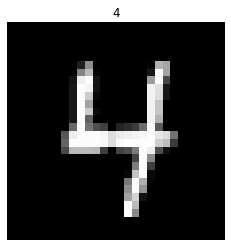

In [30]:
# visualize prediction 
vis_idx = 1
pred = model.predict(X_val[vis_idx])
vis(X_val[vis_idx].reshape(-1, 28), pred[0])

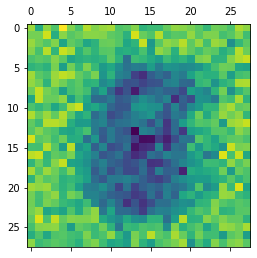

In [22]:
# visualize first layer mean weights
t = model.layers[0].W.mean(axis=1).reshape(28, 28)
plt.matshow(t)